In [1]:
import pandas as pd
import os
import warnings
import time
import config
warnings.filterwarnings("ignore")

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, RecurrentNetwork
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, MAPE, RMSE

import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


torch.set_float32_matmul_precision("high")

In [6]:
path = config.PATH_DATASETS

def get_csv_file_list(path):
    list_csv = os.listdir(path)
    return list_csv

def get_csv(path,csv_file_name):
    df = pd.read_csv(path + "\\" + csv_file_name)
    #estado.drop(columns='Unnamed: 0',inplace=True)
    #estado.data = pd.to_datetime(estado.data)
    #estado = estado.loc[estado.data >= '2022-01-01']

    df['temperature'].fillna(method='ffill', inplace=True)
    df['windSpeed'].fillna(method='ffill', inplace=True)
    df['year'] = df['year'].astype(str)
    df['hour'] = df['hour'].astype(str)
    df['month'] = df['month'].astype(str)
    df['day'] = df['day'].astype(str)
    df['dayofweek_num'] = df['dayofweek_num'].astype(str)
    df['weekend_holiday'] = df['weekend_holiday'].astype(str)
    df['house_hold'] = df['house_hold'].astype(str)
    df['precipType'] = df['precipType'].astype(str)
    df['icon'] = df['icon'].astype(str)
    df['summary'] = df['summary'].astype(str)
    df['bool_weather_missing_values'] = df['bool_weather_missing_values'].astype(str)

    return df 

In [8]:
list_csv = get_csv_file_list(path)
df = get_csv(path,list_csv[0])

In [ ]:
def run_GLU_model(df,
                     max_prediction_length = 168,
                     max_encoder_length = 720,
                     batch_size = 128,
                     path_pred = config.PATH_PREDICTIONS,
                     seed = 81):
    training_cutoff = df["time_idx"].max() - max_prediction_length

    pl.seed_everything(seed)

    training = TimeSeriesDataSet(
                    df[lambda x: df.time_idx <= training_cutoff],
                    time_idx = 'time_idx',
                    target = 'Energy_kwh',
                    group_ids = ['house_hold'],
                    time_varying_known_reals=['time_idx'],
                    time_varying_unknown_reals = ['Energy_kwh'],
                    static_categoricals=['house_hold'],
                    min_encoder_length = max_encoder_length // 2,
                    max_encoder_length = max_encoder_length,
                    min_prediction_length=1,
                    max_prediction_length = max_prediction_length,
                    categorical_encoders = {'house_hold': NaNLabelEncoder(add_nan=True, warn=True)}
        )


    validation = TimeSeriesDataSet.from_dataset(training, 
                                                df,
                                                predict = True,
                                                stop_randomization = True)

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    train_dataloader = training.to_dataloader(train = True,
                                            batch_size = batch_size,
                                            num_workers = 1)


    val_dataloader = validation.to_dataloader(train = False,
                                            batch_size = batch_size,
                                            num_workers = 1)

    rnn_GRU = RecurrentNetwork.from_dataset(
        training,
        cell_type = 'GRU',
        learning_rate = .1,
        hidden_size = 15,
        dropout = .2,
        loss = MAE(),#QuantileLoss(quantiles=[0.05,0.5,0.95]),
        optimizer = "Ranger",
        rnn_layers  = 2
        )
    
    early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00000001,
                                    patience = 15,
                                    verbose = True,
                                    mode = "min")


    lr_logger = LearningRateMonitor()
    logger_GRU = TensorBoardLogger("GRU_logs")

    checkpoint_callback = ModelCheckpoint(monitor="val_loss")

    trainer_GRU = pl.Trainer(
                            max_epochs = 350,
                            accelerator = 'gpu',
                            enable_model_summary = True,
                            limit_train_batches = 300,
                            gradient_clip_val = 0.1,
                            callbacks = [lr_logger, early_stop_callback, checkpoint_callback],
                            logger = logger_GRU,
                            enable_progress_bar=False
            )
    
    trainer_GRU.fit(
    rnn_GRU,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader)

    best_model_path = trainer_GRU.checkpoint_callback.best_model_path
    best_rnn = RecurrentNetwork.load_from_checkpoint(best_model_path)

    best_model_path = str(best_model_path)
    best_rnn = RecurrentNetwork.load_from_checkpoint(best_model_path)

    predictions = best_rnn.predict(val_dataloader, mode = "raw", return_x = True)

    df_predictions = pd.DataFrame({'time_idx':predictions.x['decoder_time_idx'][0].to('cpu').numpy(),
                                'Real':predictions.x['decoder_target'][0].to('cpu').numpy().round(3),
                                'predict':predictions.output[0][0].to('cpu').numpy().round(3).squeeze()})

    
    path_pred + "\\" + list_csv[0]
    df_predictions.to_csv(path_pred + "\\" + list_csv[0],index=False)

In [6]:
#168 is for 7 days
#720 is for 30 days
max_prediction_length = 168
max_encoder_length = 720
batch_size = 128
training_cutoff = df["time_idx"].max() - max_prediction_length

pl.seed_everything(81)

training = TimeSeriesDataSet(
                df[lambda x: df.time_idx <= training_cutoff],
                time_idx = 'time_idx',
                target = 'Energy_kwh',
                group_ids = ['house_hold'],
                time_varying_known_reals=['time_idx'],
                time_varying_unknown_reals = ['Energy_kwh'],
                static_categoricals=['house_hold'],
                min_encoder_length = max_encoder_length // 2,
                max_encoder_length = max_encoder_length,
                min_prediction_length=1,
                max_prediction_length = max_prediction_length,
                categorical_encoders = {'house_hold': NaNLabelEncoder(add_nan=True, warn=True)}
    )


validation = TimeSeriesDataSet.from_dataset(training, 
                                            df,
                                            predict = True,
                                            stop_randomization = True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_dataloader = training.to_dataloader(train = True,
                                        batch_size = batch_size,
                                        num_workers = 1)


val_dataloader = validation.to_dataloader(train = False,
                                        batch_size = batch_size,
                                        num_workers = 1)

rnn_GRU = RecurrentNetwork.from_dataset(
    training,
    cell_type = 'GRU',
    learning_rate = .1,
    hidden_size = 15,
    dropout = .2,
    loss = MAE(),#QuantileLoss(quantiles=[0.05,0.5,0.95]),
    optimizer = "Ranger",
    rnn_layers  = 2
)



Seed set to 81


In [7]:
early_stop_callback = EarlyStopping(monitor = "val_loss",
                                    min_delta = 0.00000001,
                                    patience = 15,
                                    verbose = True,
                                    mode = "min")


lr_logger = LearningRateMonitor()
logger_GRU = TensorBoardLogger("GRU_logs")

checkpoint_callback = ModelCheckpoint(monitor="val_loss")

trainer_GRU = pl.Trainer(
                        max_epochs = 350,
                        accelerator = 'gpu',
                        enable_model_summary = True,
                        limit_train_batches = 300,
                        gradient_clip_val = 0.1,
                        callbacks = [lr_logger, early_stop_callback, checkpoint_callback],
                        logger = logger_GRU,
                        enable_progress_bar=False
        )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer_GRU.fit(
    rnn_GRU,
    train_dataloaders = train_dataloader,
    val_dataloaders = val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 2     
3 | rnn              | GRU            | 2.4 K 
4 | output_projector | Linear         | 16    
----------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)
Metric val_loss improved. New best score: 0.687
Monitored metric val_loss did not improve in the last 1 records. Best score: 0.687. Signaling Trainer to stop.


In [9]:
best_model_path = trainer_GRU.checkpoint_callback.best_model_path
print(best_model_path)
best_rnn = RecurrentNetwork.load_from_checkpoint(best_model_path)

best_model_path = str(best_model_path)
best_rnn = RecurrentNetwork.load_from_checkpoint(best_model_path)

#predictions = best_rnn.predict(val_dataloader)

GRU_logs\lightning_logs\version_1\checkpoints\epoch=0-step=79.ckpt


In [10]:
predictions = best_rnn.predict(val_dataloader, mode = "raw", return_x = True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [11]:
predictions = best_rnn.predict(val_dataloader, mode = "raw", return_x = True)

df_predictions = pd.DataFrame({'time_idx':predictions.x['decoder_time_idx'][0].to('cpu').numpy(),
                               'Real':predictions.x['decoder_target'][0].to('cpu').numpy().round(3),
                               'predict':predictions.output[0][0].to('cpu').numpy().round(3).squeeze()})

path_pred = config.PATH_PREDICTIONS
path_pred + "\\" + list_csv[0]
df_predictions.to_csv(path_pred + "\\" + list_csv[0],index=False)

In [12]:
config.PATH_PREDICTIONS

'c:\\Users\\rafin\\repositorios\\Pytorch_models_park\\Predictions_csv_files'

In [18]:
path_pred = config.PATH_PREDICTIONS
path_pred + "\\" + list_csv[0]
df_predictions.to_csv(path_pred + "\\" + list_csv[0],index=False)

In [14]:
graph_df = df[lambda x: df.time_idx <= training_cutoff][-30:][['time_idx','Energy_kwh']]

In [15]:
predictions.output[0][0].to('cpu').numpy().round(3).squeeze()

array([1.947, 1.455, 1.382, 1.398, 1.422, 1.438, 1.448, 1.454, 1.459,
       1.465, 1.471, 1.476, 1.482, 1.488, 1.494, 1.5  , 1.505, 1.511,
       1.517, 1.523, 1.528, 1.534, 1.54 , 1.545, 1.551, 1.556, 1.562,
       1.567, 1.573, 1.578, 1.583, 1.589, 1.594, 1.599, 1.604, 1.609,
       1.614, 1.619, 1.624, 1.629, 1.634, 1.638, 1.643, 1.647, 1.652,
       1.656, 1.661, 1.665, 1.669, 1.673, 1.677, 1.681, 1.685, 1.689,
       1.693, 1.696, 1.7  , 1.703, 1.707, 1.71 , 1.713, 1.717, 1.72 ,
       1.723, 1.726, 1.729, 1.732, 1.734, 1.737, 1.74 , 1.742, 1.745,
       1.747, 1.75 , 1.752, 1.754, 1.757, 1.759, 1.761, 1.763, 1.765,
       1.767, 1.769, 1.77 , 1.772, 1.774, 1.776, 1.777, 1.779, 1.78 ,
       1.782, 1.783, 1.785, 1.786, 1.787, 1.789, 1.79 , 1.791, 1.792,
       1.793, 1.794, 1.795, 1.796, 1.797, 1.798, 1.799, 1.8  , 1.801,
       1.802, 1.803, 1.804, 1.804, 1.805, 1.806, 1.807, 1.807, 1.808,
       1.809, 1.809, 1.81 , 1.81 , 1.811, 1.812, 1.812, 1.813, 1.813,
       1.814, 1.814,

In [16]:
predictions.x['decoder_target'][0].to('cpu').numpy().round(3)

array([4.042, 1.386, 1.24 , 1.137, 1.336, 1.228, 1.286, 1.295, 1.655,
       1.997, 1.481, 1.327, 1.464, 0.935, 1.075, 1.088, 1.387, 3.765,
       1.883, 1.675, 1.166, 3.635, 2.486, 4.001, 2.957, 1.447, 1.138,
       1.174, 1.148, 1.148, 1.312, 1.286, 1.35 , 1.646, 0.841, 0.74 ,
       0.841, 0.843, 0.92 , 1.016, 1.11 , 1.25 , 1.279, 1.22 , 1.602,
       1.556, 1.163, 4.138, 4.231, 1.893, 1.221, 1.223, 1.366, 1.214,
       1.274, 1.235, 1.232, 1.197, 1.051, 1.517, 1.955, 3.875, 2.711,
       0.849, 1.094, 1.513, 1.301, 1.144, 1.083, 0.995, 1.034, 3.977,
       3.906, 2.272, 1.008, 1.124, 1.206, 1.149, 1.158, 1.193, 1.089,
       0.782, 0.872, 0.82 , 0.687, 0.902, 1.499, 1.444, 0.989, 1.028,
       1.138, 2.378, 2.435, 0.833, 0.88 , 3.564, 3.83 , 0.95 , 1.02 ,
       1.111, 1.056, 1.02 , 1.049, 0.996, 1.527, 1.859, 0.986, 1.105,
       2.257, 1.328, 0.997, 0.997, 0.728, 1.116, 1.679, 1.332, 1.236,
       1.248, 1.257, 4.068, 3.985, 2.   , 1.314, 1.214, 1.272, 1.346,
       1.369, 1.366,

In [ ]:
import matplotlib.pyplot as plt

def save_graph_image(predictions,df_principal,figsize= (14, 4)):
    plt.figure(figsize=figsize)

    plt.plot(df_principal['time_idx'], df_principal['Energy_kwh'],color = 'blue')
    plt.plot(predictions.x['decoder_time_idx'][0].to('cpu').numpy(), predictions.x['decoder_target'][0].to('cpu').numpy().round(3),color = 'blue',label='Real')
    plt.plot(predictions.x['decoder_time_idx'][0].to('cpu').numpy(), predictions.output[0][0].to('cpu').numpy().round(3).squeeze(),color = 'orange',label='Predict')
    plt.xlabel("Time indexs")
    plt.ylabel("Energy KW/h")
    plt.title("Line Plot with Markers")
    plt.grid(True)
    plt.legend()
    plt.savefig('energy_prediction_plot.png', dpi=300, bbox_inches='tight')

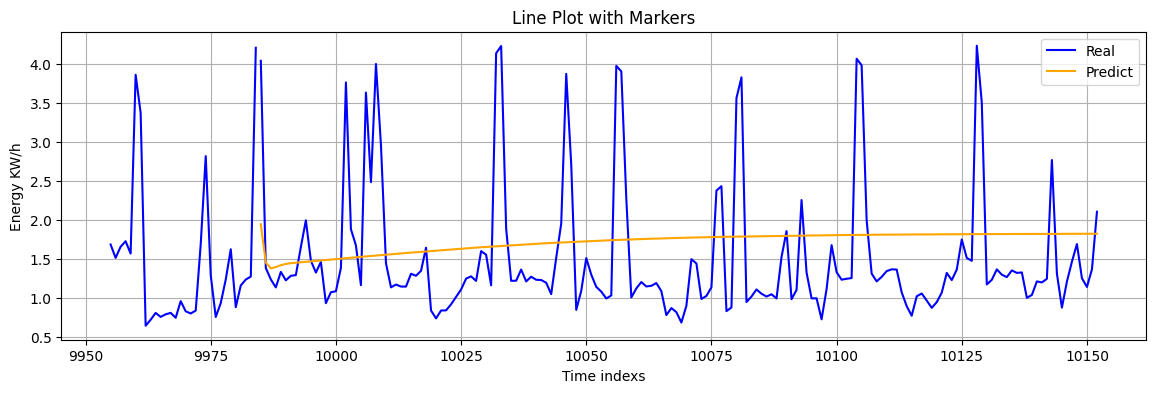

In [17]:


plt.figure(figsize=(14, 4))

plt.plot(graph_df['time_idx'], graph_df['Energy_kwh'],color = 'blue')
plt.plot(predictions.x['decoder_time_idx'][0].to('cpu').numpy(), predictions.x['decoder_target'][0].to('cpu').numpy().round(3),color = 'blue',label='Real')
plt.plot(predictions.x['decoder_time_idx'][0].to('cpu').numpy(), predictions.output[0][0].to('cpu').numpy().round(3).squeeze(),color = 'orange',label='Predict')
plt.xlabel("Time indexs")
plt.ylabel("Energy KW/h")
plt.title("Line Plot with Markers")
plt.grid(True)
plt.legend()
plt.savefig('energy_prediction_plot.png', dpi=300, bbox_inches='tight')

plt.show()




In [11]:
def run_TFT_model(df,csv_file_name,
                  learning_rate = .07,
                  hidden_size = 15,
                  dropout = .2,
                  attention_head_size = 4,
                  hidden_continuous_size = 15,
                  loss = MAE(),
                  optimizer = "Ranger",
                  lstm_layers  = 2,
                  max_prediction_length = 168,
                  max_encoder_length = 720,
                  batch_size = 128,
                  patience=1,
                  path_pred = config.PATH_PREDICTIONS_TFT,
                  path_metrics_val = config.PATH_METRICS_VALUES_TFT,
                  seed = 81,
                  select_fatures =True):
    training_cutoff = df["time_idx"].max() - max_prediction_length

    pl.seed_everything(seed)

    if select_fatures:
        training = TimeSeriesDataSet(
                        df[lambda x: df.time_idx <= training_cutoff],
                        time_idx = 'time_idx',
                        target = 'Energy_kwh',
                        group_ids = ['house_hold'],
                        time_varying_known_reals=[#'time_idx',
                                                #'temperature',
                                                #'windSpeed'
                                                ],
                        time_varying_unknown_reals = ['Energy_kwh'],
                                                    #'temperature',
                                                    #'windSpeed'],
                        static_categoricals=['house_hold'],
                        time_varying_known_categoricals = [#'year',
                                                            'month',
                                                            #'day',
                                                            'dayofweek_num',
                                                            'hour',
                                                            'bool_weather_missing_values',
                                                            'precipType',
                                                            'weekend_holiday'
                                                            #'icon',
                                                            #'summary'
                                                            ],
                        #time_varying_unknown_categoricals= ['precipType',
                        #                                   'icon',
                        #                                   'summary'],
                        min_encoder_length = max_encoder_length // 2,
                        max_encoder_length = max_encoder_length,
                        min_prediction_length=1,
                        max_prediction_length = max_prediction_length,
                        categorical_encoders = {'house_hold': NaNLabelEncoder(add_nan=True, warn=True),
                                                'precipType': NaNLabelEncoder(add_nan=True, warn=True),
                                                'icon': NaNLabelEncoder(add_nan=True, warn=True),
                                                'summary': NaNLabelEncoder(add_nan=True, warn=True)},
                        target_normalizer=None,          
                        #add_relative_time_idx=True,
                        #add_target_scales=True,
                        #add_encoder_length=True
        )
    else:
                training = TimeSeriesDataSet(
                        df[lambda x: df.time_idx <= training_cutoff],
                        time_idx = 'time_idx',
                        target = 'Energy_kwh',
                        group_ids = ['house_hold'],
                        time_varying_known_reals=['time_idx'],
                        time_varying_unknown_reals = ['Energy_kwh'],
                        static_categoricals=['house_hold'],
                        time_varying_known_categoricals = ['year',
                                                        'dayofweek_num',
                                                        'hour',
                                                        'precipType'],
                        min_encoder_length = max_encoder_length // 2,
                        max_encoder_length = max_encoder_length,
                        min_prediction_length=1,
                        max_prediction_length = max_prediction_length,
                        categorical_encoders = {'house_hold': NaNLabelEncoder(add_nan=True, warn=True),
                                                'precipType': NaNLabelEncoder(add_nan=True, warn=True),
                                                'icon': NaNLabelEncoder(add_nan=True, warn=True),
                                                'summary': NaNLabelEncoder(add_nan=True, warn=True)},
                        target_normalizer=None,          
                        add_relative_time_idx=True,
                        add_target_scales=True,
                        add_encoder_length=True
        )


    validation = TimeSeriesDataSet.from_dataset(training, 
                                                df,
                                                predict = True,
                                                stop_randomization = True)



    train_dataloader = training.to_dataloader(train = True,
                                            batch_size = batch_size,
                                            num_workers = 1)


    val_dataloader = validation.to_dataloader(train = False,
                                            batch_size = batch_size,
                                            num_workers = 1)

    
    tft = TemporalFusionTransformer.from_dataset(training,
                                                learning_rate = learning_rate,
                                                hidden_size = hidden_size,
                                                attention_head_size = attention_head_size,
                                                hidden_continuous_size = hidden_continuous_size,
                                                dropout = dropout,
                                                loss = loss,#QuantileLoss(quantiles =[0.05, 0.5, 0.95]),
                                                optimizer = optimizer,
                                                lstm_layers = lstm_layers
                                            )
    
    print(tft)

In [12]:
run_TFT_model(df=df,csv_file_name='a')

Seed set to 81


TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.2
  	"embedding_labels":                  {'house_hold': {'nan': 0, '0': 1}, 'precipType': {'nan': 0, '0': 1, '1': 2, '2': 3}, 'month': {'0': 0, '1': 1, '10': 2, '11': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11}, 'dayofweek_num': {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6}, 'hour': {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23}, 'bool_weather_missing_values': {'0': 0}, 'weekend_holiday': {'0': 0, '1': 1}}
  	"embedding_paddings":                ['house_hold', 'precipType', 'icon', 'summary']
  	"embedding_sizes":                   {'house_hold': (2, 1), 'precipType': (4, 3), 'month'